### GAN(Generative Adversarial Networks)  
- GAN은 딥러닝의 원리를 활용해 가상의 이미지를 생성하는 알고리즘  
- 가짜를 만들어 내는 파트를 ‘생성자(Generator)’, 진위를 가려내는 파트를 ‘판별자(Discriminator)’  
- 생성자(Generator)는 가상의 이미지를 만들어 내는 공장

#### 배치 정규화(Batch Normalization)  
- 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치  
- 이 과정을 통해 층의 개수가 늘어나도 안정적인 학습을 진행

In [6]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation,\
                                    LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [7]:
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")

- LeakyReLU() 함수는 ReLU() 함수에서 x 값이 음수이면 무조건 0이 되어 뉴런들이 일찍 소실되는 단점을 보완하기 위해, 0이하에서도 작은 값을 갖게 만드는 활성화 함수입니다. 케라스 함수를 이용해 ‘LeakyReLU(0.2)‘와 같은 형태로 설정하면 0보다 작을 경우 0.2를 곱하라는 의미입니다.

In [13]:
# 생성자 모델 만들기
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100,
                   activation=LeakyReLU(0.2))) # 128: 노드 수, 100: 100차원 랜덤백터 준비
generator.add(BatchNormalization()) # 배치 정규화(데이터의 배치를 정규분포로 만듬)
generator.add(Reshape((7, 7, 128))) # 컨볼루션 레이어가 받아들일 수 있는 형태로 변환 
generator.add(UpSampling2D()) # 가로 세로 크기 2배로 늘려줌
generator.add(Conv2D(64, kernel_size=5, padding='same')) # padding : 모자라는 부분 0으로 채워줌
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same',\
                    activation='tanh'))

In [14]:
# 판별자 모델 만들기
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2,\
                        input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2,\
                        padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False # 생성자가 만든 노이즈를 학습하면 안되기 때문에 디폴트로 학습 안되게

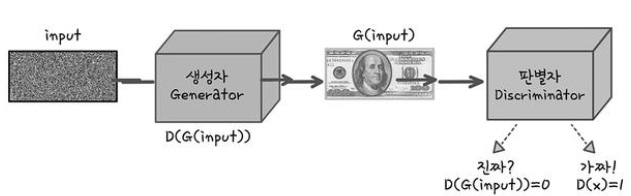

In [15]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput)) #학습X
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [16]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data() # mnist 데이터 불러오기 
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    
    # activation함수가 tanh이기 때문에 픽셀값이 모두 -1 ~ 1로 나옴 => -1 ~ 1 사이로 조정
    X_train = (X_train - 127.5) / 127.5  
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    # batch사이즈 개수만큼 전체 샘플의 인덱스를 임의로 선택
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size) 
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        # 0 ~ 1 정규분포로 랜덤 수 발생 batch사이즈 만큼 noise 100개
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # 가짜라고 학습시키기
        
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true) # 오로지 generator만 학습함
        
        # 각각의 오차가 어떻게 변하는지 찍어보기
        print("epoch:%d" % i, "d_loss:%.4f" % d_loss,\
             "g_loss:%.4f" % g_loss)
        
        # 실제 이미지를 그려서 과정을 저장하기 
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)
            

In [17]:
# gan_train(epoch, batch_size, saving_interval)
gan_train(4001, 32, 200)

epoch:0 d_loss:0.7376 g_loss:0.4843
epoch:1 d_loss:0.5166 g_loss:0.1919
epoch:2 d_loss:0.4617 g_loss:0.0666
epoch:3 d_loss:0.4711 g_loss:0.0410
epoch:4 d_loss:0.4660 g_loss:0.0595
epoch:5 d_loss:0.4437 g_loss:0.1237
epoch:6 d_loss:0.4315 g_loss:0.2567
epoch:7 d_loss:0.4303 g_loss:0.4031
epoch:8 d_loss:0.4358 g_loss:0.4430
epoch:9 d_loss:0.4253 g_loss:0.4597
epoch:10 d_loss:0.4267 g_loss:0.4437
epoch:11 d_loss:0.4279 g_loss:0.4161
epoch:12 d_loss:0.3934 g_loss:0.4111
epoch:13 d_loss:0.4176 g_loss:0.3142
epoch:14 d_loss:0.3963 g_loss:0.2974
epoch:15 d_loss:0.3312 g_loss:0.1673
epoch:16 d_loss:0.2480 g_loss:0.0725
epoch:17 d_loss:0.1763 g_loss:0.0268
epoch:18 d_loss:0.1183 g_loss:0.0154
epoch:19 d_loss:0.0656 g_loss:0.0118
epoch:20 d_loss:0.0339 g_loss:0.0320
epoch:21 d_loss:0.0360 g_loss:0.0194
epoch:22 d_loss:0.0617 g_loss:0.0188
epoch:23 d_loss:0.0489 g_loss:0.0879
epoch:24 d_loss:0.0939 g_loss:0.2412
epoch:25 d_loss:0.4544 g_loss:1.3261
epoch:26 d_loss:1.5315 g_loss:0.0624
epoch:27 d_

epoch:219 d_loss:0.4156 g_loss:1.9089
epoch:220 d_loss:0.6107 g_loss:1.7476
epoch:221 d_loss:0.4997 g_loss:1.6506
epoch:222 d_loss:0.4268 g_loss:1.7751
epoch:223 d_loss:0.4244 g_loss:1.6120
epoch:224 d_loss:0.4676 g_loss:1.8359
epoch:225 d_loss:0.3799 g_loss:2.1503
epoch:226 d_loss:0.4339 g_loss:1.9657
epoch:227 d_loss:0.3284 g_loss:1.8326
epoch:228 d_loss:0.4150 g_loss:2.1791
epoch:229 d_loss:0.4185 g_loss:2.2404
epoch:230 d_loss:0.3937 g_loss:2.5791
epoch:231 d_loss:0.3600 g_loss:2.3223
epoch:232 d_loss:0.4863 g_loss:1.8391
epoch:233 d_loss:0.5332 g_loss:1.7787
epoch:234 d_loss:0.3387 g_loss:1.9334
epoch:235 d_loss:0.5568 g_loss:1.7473
epoch:236 d_loss:0.4959 g_loss:1.6580
epoch:237 d_loss:0.7956 g_loss:1.5881
epoch:238 d_loss:0.4497 g_loss:1.6454
epoch:239 d_loss:0.4931 g_loss:2.0475
epoch:240 d_loss:0.4918 g_loss:1.8087
epoch:241 d_loss:0.4387 g_loss:1.8286
epoch:242 d_loss:0.5802 g_loss:1.7289
epoch:243 d_loss:0.5747 g_loss:1.4924
epoch:244 d_loss:0.4685 g_loss:1.4166
epoch:245 d_

epoch:435 d_loss:0.2685 g_loss:2.1393
epoch:436 d_loss:0.2979 g_loss:2.5444
epoch:437 d_loss:0.2362 g_loss:2.2501
epoch:438 d_loss:0.2634 g_loss:2.4307
epoch:439 d_loss:0.2100 g_loss:2.3035
epoch:440 d_loss:0.2737 g_loss:1.9674
epoch:441 d_loss:0.2962 g_loss:2.9103
epoch:442 d_loss:0.2129 g_loss:3.0334
epoch:443 d_loss:0.4182 g_loss:2.1912
epoch:444 d_loss:0.2645 g_loss:2.1725
epoch:445 d_loss:0.2674 g_loss:2.5239
epoch:446 d_loss:0.2275 g_loss:2.9349
epoch:447 d_loss:0.2981 g_loss:2.3750
epoch:448 d_loss:0.2177 g_loss:2.5875
epoch:449 d_loss:0.3730 g_loss:1.8924
epoch:450 d_loss:0.2152 g_loss:2.0695
epoch:451 d_loss:0.2245 g_loss:2.9140
epoch:452 d_loss:0.2054 g_loss:3.4124
epoch:453 d_loss:0.2187 g_loss:2.7243
epoch:454 d_loss:0.1770 g_loss:2.8543
epoch:455 d_loss:0.3158 g_loss:2.8051
epoch:456 d_loss:0.1617 g_loss:2.7309
epoch:457 d_loss:0.1893 g_loss:3.3107
epoch:458 d_loss:0.2572 g_loss:3.1267
epoch:459 d_loss:0.2614 g_loss:3.1842
epoch:460 d_loss:0.1630 g_loss:3.1680
epoch:461 d_

epoch:651 d_loss:0.1157 g_loss:3.8183
epoch:652 d_loss:0.2298 g_loss:4.1064
epoch:653 d_loss:0.1608 g_loss:3.5246
epoch:654 d_loss:0.6869 g_loss:2.7842
epoch:655 d_loss:1.0533 g_loss:2.2020
epoch:656 d_loss:1.5197 g_loss:1.9276
epoch:657 d_loss:1.0305 g_loss:1.9527
epoch:658 d_loss:0.7631 g_loss:2.0099
epoch:659 d_loss:0.8871 g_loss:1.8347
epoch:660 d_loss:0.5032 g_loss:2.2814
epoch:661 d_loss:0.3669 g_loss:2.7545
epoch:662 d_loss:0.2032 g_loss:3.9352
epoch:663 d_loss:0.2939 g_loss:5.0992
epoch:664 d_loss:0.5086 g_loss:5.2185
epoch:665 d_loss:0.5094 g_loss:5.0042
epoch:666 d_loss:0.3808 g_loss:4.3964
epoch:667 d_loss:0.4015 g_loss:3.0007
epoch:668 d_loss:0.3584 g_loss:2.3585
epoch:669 d_loss:0.6479 g_loss:1.5583
epoch:670 d_loss:0.4098 g_loss:1.9493
epoch:671 d_loss:0.5389 g_loss:1.7550
epoch:672 d_loss:0.7638 g_loss:1.6325
epoch:673 d_loss:0.6518 g_loss:1.3648
epoch:674 d_loss:0.7683 g_loss:1.2364
epoch:675 d_loss:0.5344 g_loss:1.5934
epoch:676 d_loss:0.4411 g_loss:1.7091
epoch:677 d_

epoch:867 d_loss:0.2884 g_loss:2.7320
epoch:868 d_loss:0.2435 g_loss:2.9858
epoch:869 d_loss:0.2443 g_loss:2.8576
epoch:870 d_loss:0.4338 g_loss:2.2716
epoch:871 d_loss:0.4425 g_loss:2.6039
epoch:872 d_loss:0.3815 g_loss:2.4033
epoch:873 d_loss:0.3442 g_loss:2.3613
epoch:874 d_loss:0.2217 g_loss:2.9802
epoch:875 d_loss:0.3881 g_loss:2.3499
epoch:876 d_loss:0.3335 g_loss:2.5241
epoch:877 d_loss:0.2060 g_loss:2.3203
epoch:878 d_loss:0.3561 g_loss:2.0046
epoch:879 d_loss:0.5908 g_loss:2.0411
epoch:880 d_loss:0.4558 g_loss:1.9344
epoch:881 d_loss:0.4312 g_loss:1.8240
epoch:882 d_loss:0.4493 g_loss:1.9408
epoch:883 d_loss:0.4570 g_loss:2.1237
epoch:884 d_loss:0.4305 g_loss:2.4716
epoch:885 d_loss:0.4575 g_loss:2.1291
epoch:886 d_loss:0.4092 g_loss:2.1669
epoch:887 d_loss:0.4873 g_loss:1.6678
epoch:888 d_loss:0.5844 g_loss:1.7877
epoch:889 d_loss:0.5388 g_loss:2.0386
epoch:890 d_loss:0.5751 g_loss:1.8964
epoch:891 d_loss:0.5228 g_loss:1.8648
epoch:892 d_loss:0.5277 g_loss:2.0448
epoch:893 d_

epoch:1081 d_loss:0.5847 g_loss:1.4336
epoch:1082 d_loss:0.3884 g_loss:1.8010
epoch:1083 d_loss:0.4834 g_loss:2.0261
epoch:1084 d_loss:0.6046 g_loss:1.4764
epoch:1085 d_loss:0.3644 g_loss:1.6808
epoch:1086 d_loss:0.3840 g_loss:1.6449
epoch:1087 d_loss:0.5002 g_loss:1.2660
epoch:1088 d_loss:0.4086 g_loss:1.7920
epoch:1089 d_loss:0.3754 g_loss:1.4036
epoch:1090 d_loss:0.5004 g_loss:1.6754
epoch:1091 d_loss:0.4293 g_loss:2.0219
epoch:1092 d_loss:0.3255 g_loss:1.8660
epoch:1093 d_loss:0.3854 g_loss:1.9729
epoch:1094 d_loss:0.3420 g_loss:2.1321
epoch:1095 d_loss:0.3933 g_loss:2.1592
epoch:1096 d_loss:0.4242 g_loss:1.7850
epoch:1097 d_loss:0.2654 g_loss:2.2415
epoch:1098 d_loss:0.2235 g_loss:2.2706
epoch:1099 d_loss:0.3666 g_loss:2.2773
epoch:1100 d_loss:0.2617 g_loss:2.6488
epoch:1101 d_loss:0.3269 g_loss:2.8062
epoch:1102 d_loss:0.2928 g_loss:2.5505
epoch:1103 d_loss:0.2920 g_loss:2.6769
epoch:1104 d_loss:0.3800 g_loss:2.1386
epoch:1105 d_loss:0.3555 g_loss:2.0106
epoch:1106 d_loss:0.2690 

epoch:1292 d_loss:0.3912 g_loss:1.8437
epoch:1293 d_loss:0.4478 g_loss:2.1715
epoch:1294 d_loss:0.3163 g_loss:3.0365
epoch:1295 d_loss:0.3245 g_loss:2.6304
epoch:1296 d_loss:0.5291 g_loss:1.9617
epoch:1297 d_loss:0.4565 g_loss:1.5797
epoch:1298 d_loss:0.5752 g_loss:1.6996
epoch:1299 d_loss:0.4254 g_loss:2.0378
epoch:1300 d_loss:0.4477 g_loss:1.9457
epoch:1301 d_loss:0.3564 g_loss:2.2543
epoch:1302 d_loss:0.6495 g_loss:1.9095
epoch:1303 d_loss:0.6186 g_loss:1.8961
epoch:1304 d_loss:0.3177 g_loss:2.1065
epoch:1305 d_loss:0.4940 g_loss:1.7342
epoch:1306 d_loss:0.3772 g_loss:2.0819
epoch:1307 d_loss:0.3205 g_loss:2.2680
epoch:1308 d_loss:0.4082 g_loss:1.9300
epoch:1309 d_loss:0.3381 g_loss:2.2626
epoch:1310 d_loss:0.5220 g_loss:2.2333
epoch:1311 d_loss:0.3826 g_loss:2.1315
epoch:1312 d_loss:0.3226 g_loss:2.3699
epoch:1313 d_loss:0.3495 g_loss:2.2125
epoch:1314 d_loss:0.2469 g_loss:2.1377
epoch:1315 d_loss:0.2920 g_loss:2.1458
epoch:1316 d_loss:0.3762 g_loss:2.3900
epoch:1317 d_loss:0.4635 

epoch:1503 d_loss:0.4934 g_loss:1.7762
epoch:1504 d_loss:0.4739 g_loss:1.6531
epoch:1505 d_loss:0.5310 g_loss:2.0657
epoch:1506 d_loss:0.5403 g_loss:1.9833
epoch:1507 d_loss:0.5786 g_loss:2.1460
epoch:1508 d_loss:0.4194 g_loss:2.3122
epoch:1509 d_loss:0.3682 g_loss:1.9287
epoch:1510 d_loss:0.4609 g_loss:1.9975
epoch:1511 d_loss:0.4811 g_loss:1.4834
epoch:1512 d_loss:0.6337 g_loss:1.3402
epoch:1513 d_loss:0.5039 g_loss:1.5680
epoch:1514 d_loss:0.3574 g_loss:2.3834
epoch:1515 d_loss:0.5792 g_loss:2.1679
epoch:1516 d_loss:0.5823 g_loss:2.0646
epoch:1517 d_loss:0.4465 g_loss:1.7300
epoch:1518 d_loss:0.6173 g_loss:1.5991
epoch:1519 d_loss:0.6208 g_loss:1.7740
epoch:1520 d_loss:0.6061 g_loss:1.7338
epoch:1521 d_loss:0.5807 g_loss:1.7815
epoch:1522 d_loss:0.4199 g_loss:2.0133
epoch:1523 d_loss:0.3616 g_loss:2.1012
epoch:1524 d_loss:0.4193 g_loss:2.1513
epoch:1525 d_loss:0.4077 g_loss:1.7244
epoch:1526 d_loss:0.3364 g_loss:2.1246
epoch:1527 d_loss:0.5215 g_loss:1.6762
epoch:1528 d_loss:0.3877 

epoch:1714 d_loss:0.4025 g_loss:1.9143
epoch:1715 d_loss:0.5671 g_loss:2.0181
epoch:1716 d_loss:0.6059 g_loss:1.4674
epoch:1717 d_loss:0.5115 g_loss:1.6940
epoch:1718 d_loss:0.5316 g_loss:1.5896
epoch:1719 d_loss:0.4247 g_loss:1.8501
epoch:1720 d_loss:0.6926 g_loss:1.3586
epoch:1721 d_loss:0.6507 g_loss:1.5099
epoch:1722 d_loss:0.5345 g_loss:1.5830
epoch:1723 d_loss:0.5118 g_loss:1.6795
epoch:1724 d_loss:0.5110 g_loss:1.6332
epoch:1725 d_loss:0.5587 g_loss:1.5338
epoch:1726 d_loss:0.4882 g_loss:1.6485
epoch:1727 d_loss:0.4487 g_loss:1.6471
epoch:1728 d_loss:0.4083 g_loss:1.7833
epoch:1729 d_loss:0.5222 g_loss:1.6224
epoch:1730 d_loss:0.4869 g_loss:2.0897
epoch:1731 d_loss:0.6970 g_loss:1.9276
epoch:1732 d_loss:0.4447 g_loss:1.9396
epoch:1733 d_loss:0.4160 g_loss:1.3896
epoch:1734 d_loss:0.4047 g_loss:1.7588
epoch:1735 d_loss:0.4795 g_loss:1.5454
epoch:1736 d_loss:0.4916 g_loss:1.7337
epoch:1737 d_loss:0.4572 g_loss:1.8551
epoch:1738 d_loss:0.5333 g_loss:1.8973
epoch:1739 d_loss:0.4421 

epoch:1925 d_loss:0.3690 g_loss:1.7593
epoch:1926 d_loss:0.4202 g_loss:2.3776
epoch:1927 d_loss:0.3650 g_loss:2.0842
epoch:1928 d_loss:0.3594 g_loss:2.0851
epoch:1929 d_loss:0.3596 g_loss:2.1511
epoch:1930 d_loss:0.2789 g_loss:1.8960
epoch:1931 d_loss:0.4625 g_loss:1.8549
epoch:1932 d_loss:0.4546 g_loss:2.1318
epoch:1933 d_loss:0.5027 g_loss:1.7714
epoch:1934 d_loss:0.4295 g_loss:1.6497
epoch:1935 d_loss:0.4909 g_loss:1.7074
epoch:1936 d_loss:0.4403 g_loss:1.9802
epoch:1937 d_loss:0.4536 g_loss:2.3115
epoch:1938 d_loss:0.4508 g_loss:1.9096
epoch:1939 d_loss:0.4808 g_loss:1.4784
epoch:1940 d_loss:0.4673 g_loss:1.2659
epoch:1941 d_loss:0.4623 g_loss:1.2113
epoch:1942 d_loss:0.3943 g_loss:1.6669
epoch:1943 d_loss:0.5067 g_loss:2.1102
epoch:1944 d_loss:0.5059 g_loss:1.6681
epoch:1945 d_loss:0.5761 g_loss:1.8322
epoch:1946 d_loss:0.4007 g_loss:1.6409
epoch:1947 d_loss:0.5103 g_loss:1.8458
epoch:1948 d_loss:0.4507 g_loss:1.5614
epoch:1949 d_loss:0.5720 g_loss:2.0981
epoch:1950 d_loss:0.4371 

epoch:2136 d_loss:0.4403 g_loss:1.5234
epoch:2137 d_loss:0.5379 g_loss:1.3618
epoch:2138 d_loss:0.4396 g_loss:1.6315
epoch:2139 d_loss:0.2950 g_loss:2.0771
epoch:2140 d_loss:0.5109 g_loss:1.7796
epoch:2141 d_loss:0.4487 g_loss:1.8925
epoch:2142 d_loss:0.4226 g_loss:1.9168
epoch:2143 d_loss:0.5328 g_loss:1.9211
epoch:2144 d_loss:0.3478 g_loss:1.7982
epoch:2145 d_loss:0.5576 g_loss:1.4332
epoch:2146 d_loss:0.3930 g_loss:1.9123
epoch:2147 d_loss:0.3471 g_loss:1.8760
epoch:2148 d_loss:0.4916 g_loss:1.8439
epoch:2149 d_loss:0.4525 g_loss:2.1366
epoch:2150 d_loss:0.5483 g_loss:1.6986
epoch:2151 d_loss:0.5309 g_loss:1.8925
epoch:2152 d_loss:0.4071 g_loss:2.0380
epoch:2153 d_loss:0.4355 g_loss:2.0935
epoch:2154 d_loss:0.5390 g_loss:1.8049
epoch:2155 d_loss:0.6537 g_loss:1.4496
epoch:2156 d_loss:0.6726 g_loss:1.6187
epoch:2157 d_loss:0.6511 g_loss:1.6932
epoch:2158 d_loss:0.5001 g_loss:1.7892
epoch:2159 d_loss:0.4205 g_loss:1.9810
epoch:2160 d_loss:0.6114 g_loss:1.6343
epoch:2161 d_loss:0.5225 

epoch:2347 d_loss:0.2719 g_loss:1.7550
epoch:2348 d_loss:0.4641 g_loss:2.1694
epoch:2349 d_loss:0.3879 g_loss:2.4027
epoch:2350 d_loss:0.3095 g_loss:2.0752
epoch:2351 d_loss:0.3289 g_loss:2.1645
epoch:2352 d_loss:0.6173 g_loss:1.8833
epoch:2353 d_loss:0.4974 g_loss:1.7182
epoch:2354 d_loss:0.3721 g_loss:1.7690
epoch:2355 d_loss:0.4578 g_loss:2.1063
epoch:2356 d_loss:0.4844 g_loss:1.5679
epoch:2357 d_loss:0.5151 g_loss:1.9919
epoch:2358 d_loss:0.4007 g_loss:1.8103
epoch:2359 d_loss:0.4120 g_loss:1.7978
epoch:2360 d_loss:0.5527 g_loss:1.8469
epoch:2361 d_loss:0.5754 g_loss:1.8013
epoch:2362 d_loss:0.6046 g_loss:1.5767
epoch:2363 d_loss:0.4622 g_loss:1.5089
epoch:2364 d_loss:0.4207 g_loss:1.6859
epoch:2365 d_loss:0.5395 g_loss:1.6027
epoch:2366 d_loss:0.5015 g_loss:2.0107
epoch:2367 d_loss:0.4443 g_loss:1.9189
epoch:2368 d_loss:0.4712 g_loss:1.9713
epoch:2369 d_loss:0.4667 g_loss:1.8740
epoch:2370 d_loss:0.4305 g_loss:1.6964
epoch:2371 d_loss:0.4370 g_loss:1.9407
epoch:2372 d_loss:0.5667 

epoch:2558 d_loss:0.5329 g_loss:1.4380
epoch:2559 d_loss:0.5746 g_loss:1.6121
epoch:2560 d_loss:0.6450 g_loss:1.3488
epoch:2561 d_loss:0.4918 g_loss:1.4098
epoch:2562 d_loss:0.3938 g_loss:1.6423
epoch:2563 d_loss:0.4001 g_loss:1.8228
epoch:2564 d_loss:0.7154 g_loss:1.3344
epoch:2565 d_loss:0.6101 g_loss:1.5757
epoch:2566 d_loss:0.5056 g_loss:1.3931
epoch:2567 d_loss:0.5048 g_loss:1.5767
epoch:2568 d_loss:0.5046 g_loss:1.4011
epoch:2569 d_loss:0.4901 g_loss:1.4702
epoch:2570 d_loss:0.4151 g_loss:1.7218
epoch:2571 d_loss:0.4795 g_loss:1.4049
epoch:2572 d_loss:0.4277 g_loss:1.4119
epoch:2573 d_loss:0.5096 g_loss:1.6195
epoch:2574 d_loss:0.5644 g_loss:1.5689
epoch:2575 d_loss:0.5539 g_loss:1.3666
epoch:2576 d_loss:0.5135 g_loss:1.6633
epoch:2577 d_loss:0.5037 g_loss:1.8519
epoch:2578 d_loss:0.5128 g_loss:1.4321
epoch:2579 d_loss:0.6084 g_loss:1.6461
epoch:2580 d_loss:0.5540 g_loss:1.2512
epoch:2581 d_loss:0.5030 g_loss:1.3157
epoch:2582 d_loss:0.4809 g_loss:1.6099
epoch:2583 d_loss:0.6058 

epoch:2769 d_loss:0.5185 g_loss:1.5854
epoch:2770 d_loss:0.4200 g_loss:1.6723
epoch:2771 d_loss:0.4778 g_loss:1.6777
epoch:2772 d_loss:0.4818 g_loss:1.6296
epoch:2773 d_loss:0.6167 g_loss:1.7669
epoch:2774 d_loss:0.5229 g_loss:1.4138
epoch:2775 d_loss:0.5106 g_loss:1.2722
epoch:2776 d_loss:0.4241 g_loss:1.6429
epoch:2777 d_loss:0.5226 g_loss:1.6195
epoch:2778 d_loss:0.4861 g_loss:1.8798
epoch:2779 d_loss:0.5595 g_loss:1.7608
epoch:2780 d_loss:0.3679 g_loss:1.9704
epoch:2781 d_loss:0.5705 g_loss:1.5087
epoch:2782 d_loss:0.4749 g_loss:1.8916
epoch:2783 d_loss:0.6058 g_loss:2.0688
epoch:2784 d_loss:0.5077 g_loss:1.9083
epoch:2785 d_loss:0.4865 g_loss:1.9946
epoch:2786 d_loss:0.4497 g_loss:1.7335
epoch:2787 d_loss:0.4398 g_loss:1.4411
epoch:2788 d_loss:0.3689 g_loss:1.5089
epoch:2789 d_loss:0.4805 g_loss:1.4130
epoch:2790 d_loss:0.3827 g_loss:1.9831
epoch:2791 d_loss:0.4204 g_loss:2.0185
epoch:2792 d_loss:0.2529 g_loss:1.6491
epoch:2793 d_loss:0.4811 g_loss:2.1051
epoch:2794 d_loss:0.3799 

epoch:2980 d_loss:0.5387 g_loss:1.6999
epoch:2981 d_loss:0.8487 g_loss:1.4005
epoch:2982 d_loss:0.5673 g_loss:1.3735
epoch:2983 d_loss:0.6152 g_loss:1.7351
epoch:2984 d_loss:0.5090 g_loss:1.7501
epoch:2985 d_loss:0.6019 g_loss:1.8422
epoch:2986 d_loss:0.6398 g_loss:1.4842
epoch:2987 d_loss:0.4412 g_loss:1.6259
epoch:2988 d_loss:0.4638 g_loss:1.7250
epoch:2989 d_loss:0.5937 g_loss:1.6639
epoch:2990 d_loss:0.4526 g_loss:1.7060
epoch:2991 d_loss:0.5400 g_loss:1.7826
epoch:2992 d_loss:0.4110 g_loss:1.7130
epoch:2993 d_loss:0.4618 g_loss:1.7151
epoch:2994 d_loss:0.4807 g_loss:1.7580
epoch:2995 d_loss:0.4282 g_loss:2.0402
epoch:2996 d_loss:0.3015 g_loss:1.9003
epoch:2997 d_loss:0.3213 g_loss:2.2649
epoch:2998 d_loss:0.3715 g_loss:1.9126
epoch:2999 d_loss:0.4546 g_loss:1.5110
epoch:3000 d_loss:0.4076 g_loss:1.9961
epoch:3001 d_loss:0.5958 g_loss:2.1738
epoch:3002 d_loss:0.3910 g_loss:2.0046
epoch:3003 d_loss:0.4980 g_loss:2.1004
epoch:3004 d_loss:0.3290 g_loss:2.3062
epoch:3005 d_loss:0.4539 

epoch:3191 d_loss:0.3394 g_loss:1.9555
epoch:3192 d_loss:0.3887 g_loss:1.8557
epoch:3193 d_loss:0.3795 g_loss:2.3188
epoch:3194 d_loss:0.3733 g_loss:2.0637
epoch:3195 d_loss:0.3931 g_loss:2.0816
epoch:3196 d_loss:0.4355 g_loss:1.9266
epoch:3197 d_loss:0.4756 g_loss:2.0530
epoch:3198 d_loss:0.4291 g_loss:2.1176
epoch:3199 d_loss:0.3680 g_loss:2.4939
epoch:3200 d_loss:0.4442 g_loss:2.4111
epoch:3201 d_loss:0.5907 g_loss:1.4130
epoch:3202 d_loss:0.6750 g_loss:1.3438
epoch:3203 d_loss:0.5227 g_loss:1.5689
epoch:3204 d_loss:0.4901 g_loss:1.6803
epoch:3205 d_loss:0.4237 g_loss:1.8096
epoch:3206 d_loss:0.5262 g_loss:1.8702
epoch:3207 d_loss:0.6505 g_loss:1.7084
epoch:3208 d_loss:0.5678 g_loss:1.6174
epoch:3209 d_loss:0.4699 g_loss:2.0491
epoch:3210 d_loss:0.6009 g_loss:1.4441
epoch:3211 d_loss:0.4563 g_loss:1.4040
epoch:3212 d_loss:0.5283 g_loss:1.6287
epoch:3213 d_loss:0.5360 g_loss:1.6780
epoch:3214 d_loss:0.4369 g_loss:1.8443
epoch:3215 d_loss:0.4594 g_loss:1.9890
epoch:3216 d_loss:0.5911 

epoch:3402 d_loss:0.5073 g_loss:1.4559
epoch:3403 d_loss:0.4144 g_loss:1.9068
epoch:3404 d_loss:0.5333 g_loss:2.0774
epoch:3405 d_loss:0.4624 g_loss:1.5126
epoch:3406 d_loss:0.5183 g_loss:1.5232
epoch:3407 d_loss:0.5262 g_loss:1.6332
epoch:3408 d_loss:0.4502 g_loss:1.9653
epoch:3409 d_loss:0.5464 g_loss:1.7142
epoch:3410 d_loss:0.3854 g_loss:2.2130
epoch:3411 d_loss:0.3925 g_loss:2.1902
epoch:3412 d_loss:0.3840 g_loss:1.8832
epoch:3413 d_loss:0.4153 g_loss:1.7621
epoch:3414 d_loss:0.2910 g_loss:2.1431
epoch:3415 d_loss:0.4617 g_loss:1.7784
epoch:3416 d_loss:0.4493 g_loss:1.6838
epoch:3417 d_loss:0.3406 g_loss:1.8393
epoch:3418 d_loss:0.5382 g_loss:2.1155
epoch:3419 d_loss:0.4768 g_loss:1.6896
epoch:3420 d_loss:0.3298 g_loss:1.9669
epoch:3421 d_loss:0.4674 g_loss:1.6279
epoch:3422 d_loss:0.4104 g_loss:1.7880
epoch:3423 d_loss:0.4407 g_loss:1.8988
epoch:3424 d_loss:0.5190 g_loss:1.9642
epoch:3425 d_loss:0.5123 g_loss:1.6353
epoch:3426 d_loss:0.4226 g_loss:1.8795
epoch:3427 d_loss:0.4554 

epoch:3613 d_loss:0.3807 g_loss:1.9583
epoch:3614 d_loss:0.4252 g_loss:2.0183
epoch:3615 d_loss:0.3442 g_loss:1.7456
epoch:3616 d_loss:0.4134 g_loss:1.5219
epoch:3617 d_loss:0.3944 g_loss:2.1112
epoch:3618 d_loss:0.3604 g_loss:2.2874
epoch:3619 d_loss:0.6345 g_loss:1.7785
epoch:3620 d_loss:0.5061 g_loss:1.6310
epoch:3621 d_loss:0.5631 g_loss:1.2444
epoch:3622 d_loss:0.5368 g_loss:2.1431
epoch:3623 d_loss:0.4896 g_loss:1.6615
epoch:3624 d_loss:0.6108 g_loss:1.7265
epoch:3625 d_loss:0.5201 g_loss:1.7467
epoch:3626 d_loss:0.5271 g_loss:1.4511
epoch:3627 d_loss:0.5384 g_loss:1.1568
epoch:3628 d_loss:0.5347 g_loss:1.5350
epoch:3629 d_loss:0.4689 g_loss:1.4303
epoch:3630 d_loss:0.4304 g_loss:2.3800
epoch:3631 d_loss:0.6568 g_loss:1.3560
epoch:3632 d_loss:0.4179 g_loss:1.6393
epoch:3633 d_loss:0.4793 g_loss:1.9544
epoch:3634 d_loss:0.3720 g_loss:1.7218
epoch:3635 d_loss:0.4412 g_loss:1.9702
epoch:3636 d_loss:0.3110 g_loss:2.3742
epoch:3637 d_loss:0.4347 g_loss:1.9577
epoch:3638 d_loss:0.3784 

epoch:3824 d_loss:0.5031 g_loss:1.5651
epoch:3825 d_loss:0.4602 g_loss:1.6744
epoch:3826 d_loss:0.4810 g_loss:2.0686
epoch:3827 d_loss:0.4267 g_loss:1.8593
epoch:3828 d_loss:0.6154 g_loss:1.6090
epoch:3829 d_loss:0.3901 g_loss:1.8419
epoch:3830 d_loss:0.5419 g_loss:1.7330
epoch:3831 d_loss:0.5542 g_loss:1.5332
epoch:3832 d_loss:0.5097 g_loss:1.4669
epoch:3833 d_loss:0.5270 g_loss:1.5168
epoch:3834 d_loss:0.3555 g_loss:2.2162
epoch:3835 d_loss:0.4763 g_loss:2.0282
epoch:3836 d_loss:0.4447 g_loss:2.1047
epoch:3837 d_loss:0.4953 g_loss:1.7768
epoch:3838 d_loss:0.6259 g_loss:1.7293
epoch:3839 d_loss:0.5861 g_loss:1.4856
epoch:3840 d_loss:0.3733 g_loss:1.5508
epoch:3841 d_loss:0.4573 g_loss:1.5990
epoch:3842 d_loss:0.4494 g_loss:1.7424
epoch:3843 d_loss:0.5598 g_loss:1.5511
epoch:3844 d_loss:0.4240 g_loss:1.8373
epoch:3845 d_loss:0.6802 g_loss:1.7612
epoch:3846 d_loss:0.5750 g_loss:1.4570
epoch:3847 d_loss:0.5108 g_loss:1.1994
epoch:3848 d_loss:0.5081 g_loss:1.3805
epoch:3849 d_loss:0.4342 

<ipython-input-16-b9da8b629b30>:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(5, 5)
